In [1]:
import pre_processing as pp
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv1D, MaxPooling2D, MaxPooling1D, ConvLSTM2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow import keras

import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [195]:
files = pp.get_files(" ")
data = pp.get_data("Chest_Left", files)

In [196]:
data, tgts, students = pp.get_data_by_datapoints(data, points_wanted = 25)
tgts = pp.convert_targets(tgts)

In [197]:
scaler = StandardScaler()
data = scaler.fit_transform(data)

In [198]:
def balance_classes(data, tgts, students):
    un = np.unique(tgts, return_counts=True)
    m = np.min(un[1])
    balanced = []
    for u in un[0]:
        ts = np.argwhere(tgts==u)
        randinds = list(np.random.choice(ts.flatten(),m))
        balanced += randinds

    data = data[balanced]
    tgts = tgts[balanced]
    students = students[balanced]
    return np.array(data), np.array(tgts), np.array(students)

In [199]:
data, tgts, students = balance_classes(data, tgts, students)

In [200]:
cleaned_data, targets, student_data, student_targets = pp.leave_one_out(data, tgts, students)

In [201]:
cleaned_data

array([[ 1.88246834,  1.8986939 ,  1.92586966, ...,  0.78644119,
         0.81294601,  0.82693732],
       [-0.08503006, -0.08989256, -0.08575967, ...,  0.53475697,
         0.55945498,  0.56659683],
       [-0.39348687, -0.42295361, -0.42266403, ..., -0.31411877,
        -0.31709808, -0.32074694],
       ...,
       [-0.01714783, -0.00730645, -0.00411887, ..., -0.85372573,
        -0.85979701, -0.85981077],
       [-0.13987889, -0.11651571, -0.12385871, ..., -0.74252797,
        -0.81019017, -0.86825693],
       [ 0.17237935,  0.1605824 ,  0.16678254, ...,  0.60326276,
         0.60608542,  0.59789728]])

In [202]:
timestep = 25
x_train = np.array([[c[0:timestep], c[timestep:2*timestep], c[2*timestep:3*timestep]] for c in cleaned_data])
x_test = np.array([[c[0:timestep], c[timestep:2*timestep], c[2*timestep:3*timestep]] for c in student_data])

In [203]:
y_train = targets
y_test = student_targets

In [204]:
len(x_test)

305

In [205]:
x_train.shape

(14944, 3, 25)

In [206]:
x_train[0].shape

(3, 25)

## CNN

In [207]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(16, (2,2), activation='relu', input_shape = model.output_shape))
model.add(Dropout(0.2))

model.add(Conv2D(32, (2,2), activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(13, activation='softmax'))

In [208]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [209]:
history = model.fit(x_train, y_train, epochs=5, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

Train on 14944 samples, validate on 305 samples
Epoch 1/5
14944/14944 [==============================] - 9s 618us/sample - loss: 1.6116 - accuracy: 0.4500 - val_loss: 1.3230 - val_accuracy: 0.4885
Epoch 2/5
14944/14944 [==============================] - 8s 539us/sample - loss: 1.1037 - accuracy: 0.6025 - val_loss: 1.6683 - val_accuracy: 0.5213
Epoch 3/5
14944/14944 [==============================] - 8s 534us/sample - loss: 0.9571 - accuracy: 0.6463 - val_loss: 1.6935 - val_accuracy: 0.4656
Epoch 4/5
14944/14944 [==============================] - 8s 535us/sample - loss: 0.8882 - accuracy: 0.6702 - val_loss: 1.8965 - val_accuracy: 0.4754
Epoch 5/5
14944/14944 [==============================] - 8s 539us/sample - loss: 0.8504 - accuracy: 0.6829 - val_loss: 1.8871 - val_accuracy: 0.5311


In [210]:
y_pred = model.predict_classes(x_test)

(<Figure size 936x936 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

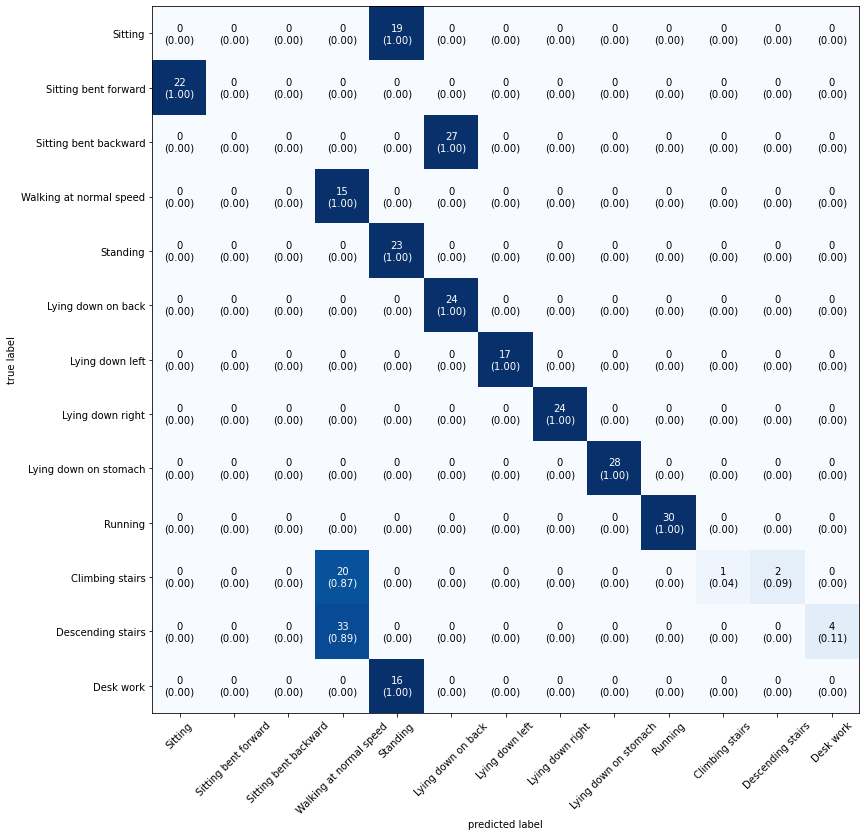

In [211]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=pp.new_activity_dict.values(), show_normed=True, figsize=(13,13))

## CNN using L2 w/wo Dropout

In [137]:
model = Sequential()
model.add(tf.keras.layers.Reshape((3, 25, 1), input_shape=(3,25)))
model.add(Conv2D(128, (2,2), activation='relu', input_shape = model.output_shape, kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (2,2), activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=1))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))

In [138]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [139]:
history = model.fit(x_train, y_train, epochs=10, batch_size = 32, validation_data = (x_test, y_test), verbose=1)

Train on 14942 samples, validate on 307 samples
Epoch 1/10
14942/14942 [==============================] - 33s 2ms/sample - loss: 1.2742 - accuracy: 0.5526 - val_loss: 0.6232 - val_accuracy: 0.8371
Epoch 2/10
14942/14942 [==============================] - 31s 2ms/sample - loss: 0.8868 - accuracy: 0.6718 - val_loss: 0.5484 - val_accuracy: 0.8697
Epoch 3/10
14942/14942 [==============================] - 32s 2ms/sample - loss: 0.8017 - accuracy: 0.7062 - val_loss: 0.5522 - val_accuracy: 0.8827
Epoch 4/10
14942/14942 [==============================] - 32s 2ms/sample - loss: 0.7331 - accuracy: 0.7266 - val_loss: 0.7384 - val_accuracy: 0.7785
Epoch 5/10
14942/14942 [==============================] - 32s 2ms/sample - loss: 0.6852 - accuracy: 0.7461 - val_loss: 0.5588 - val_accuracy: 0.8306
Epoch 6/10
14942/14942 [==============================] - 34s 2ms/sample - loss: 0.6391 - accuracy: 0.7645 - val_loss: 0.5674 - val_accuracy: 0.8469
Epoch 7/10
14942/14942 [==============================] - 

In [140]:
y_pred = model.predict_classes(x_test)

(<Figure size 936x936 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

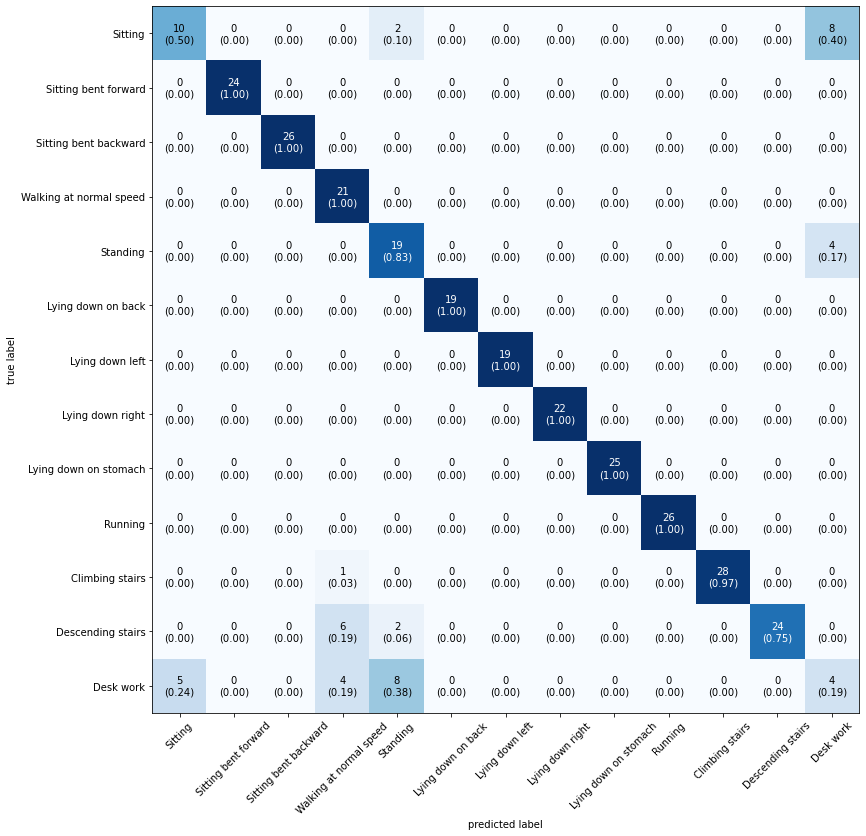

In [141]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=pp.new_activity_dict.values(), show_normed=True, figsize=(13,13))

## Convert Model to TF Lite

In [142]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Float model size = 1417KBs.


In [143]:
f = open('chesthar.tflite', "wb")
f.write(tflite_float_model)
f.close()

print('`chesthar.tflite` has been downloaded')

`chesthar.tflite` has been downloaded


## 1D-CNN With LSTM

In [219]:
model = Sequential()

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = x_train[0].shape)))
#model.add(TimeDistributed(Dropout(0.1)))

model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
#model.add(TimeDistributed(Dropout(0.2)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(100))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(14, activation='softmax'))

In [220]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [221]:
history = model.fit(x_train, y_train, epochs=5, batch_size = 16, validation_data = (x_test, y_test), verbose=1)

ValueError: input tensor must have rank 3

## LSTM

In [222]:
model = Sequential()
model.add((LSTM(100, return_sequences=True, input_shape = (3,25), kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001))))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))


model.add(Dense(14, activation='softmax', kernel_regularizer=l2(0.000001), bias_regularizer=l2(0.000001)))
model.summary()


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 100)            50400     
_________________________________________________________________
flatten_26 (Flatten)         (None, 300)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_53 (Dense)             (None, 14)                1414      
Total params: 81,914
Trainable params: 81,914
Non-trainable params: 0
_________________________________________________________________


In [223]:
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [225]:
history = model.fit(x_train, y_train, epochs=8, batch_size=16, validation_data = (x_test, y_test),verbose=1)

Train on 16085 samples, validate on 337 samples
Epoch 1/8
16085/16085 [==============================] - 21s 1ms/sample - loss: 1.4910 - accuracy: 0.4897 - val_loss: 1.1345 - val_accuracy: 0.6261
Epoch 2/8
 5136/16085 [========>.....................] - ETA: 10s - loss: 1.1786 - accuracy: 0.5752

KeyboardInterrupt: 

In [140]:
y_pred = model.predict_classes(lx_test)

/Users/azamkhan/miniconda3/envs/pdiot/lib/python3.7/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


(<Figure size 1008x1008 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

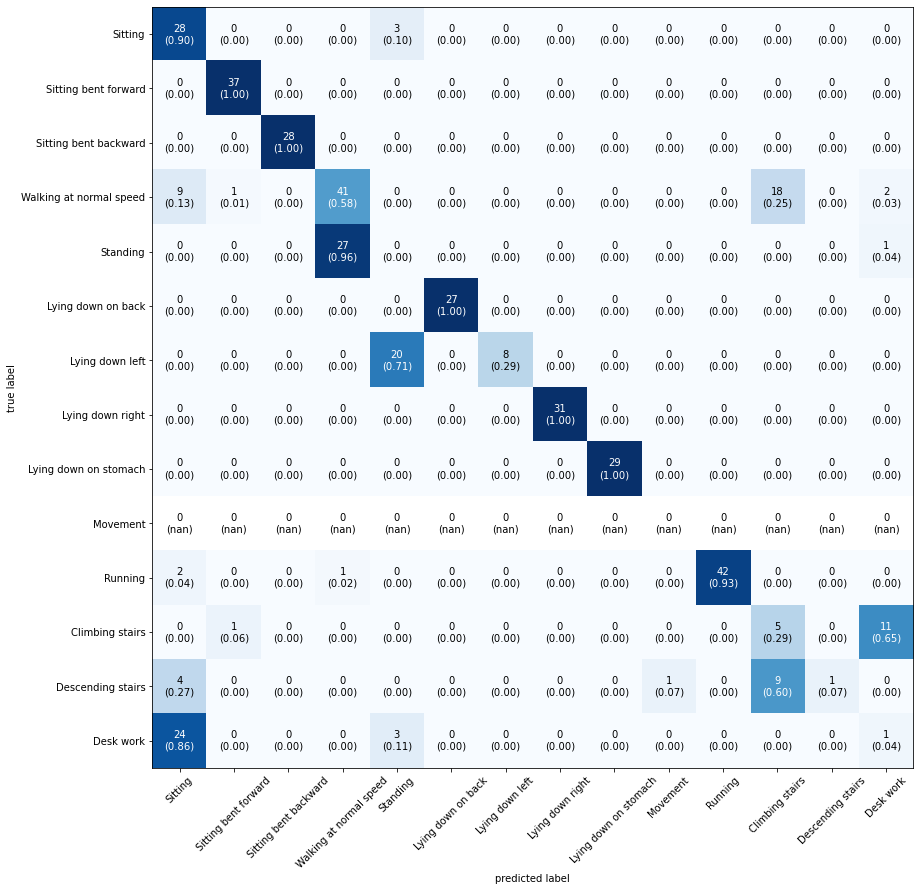

In [141]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=pp.new_activity_dict.values(), show_normed=True, figsize=(14,14))